In [2]:
# Clear workspace
%reset

# standard packages
from math import e
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from scipy.stats import sem
pd.options.display.max_colwidth = 100

# SGL packages
from group_lasso import LogisticGroupLasso
LogisticGroupLasso.LOG_LOSSES = True

%reload_ext autoreload
%autoreload 2

working_dir = "~/Desktop/hif2gene"


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
seed = 360
np.random.seed(seed)

## Load in HIFs + Clusters 

In [5]:
# Load in HIF dataset with labels
# NAs removed, already converted to patient-level
df = pd.read_csv("{0}/data/genetic_data/HRD/datasets/pancancer.HRD_Score.joined.USE.csv".format(working_dir))
df = df.iloc[:,1:]

In [7]:
# Normalize HIFs and define X, y
X = df.iloc[:,1:608]
X_normalized = (X-X.mean())/X.std()

In [8]:
y = df.iloc[:,609]
print(np.sum(y))

318


In [10]:
# Load in clusters
clusters = pd.read_csv("{0}/data/hif_clusters/pancancer.hif.clusters.csv".format(working_dir))
print("Number of Clusters: {0}".format(len(set(clusters['x']))))


Number of Clusters: 20


## Define Nested CV Parameters

In [11]:
num_outer_loops = 3 # for estimating generalization error
num_inner_loops = 5 # for hyper-parameter tuning
training_aurocs = [0.0, 0.0, 0.0]
generalization_aurocs = [0.0, 0.0, 0.0]
training_auprcs = [0.0, 0.0, 0.0]
generalization_auprcs = [0.0, 0.0, 0.0]

# Define outer loops (A, B, and C)
X_train_AB, X_train_C, y_train_AB, y_train_C = train_test_split(X_normalized, y, test_size=1/3, random_state=seed, stratify=y)
X_train_A, X_train_B, y_train_A, y_train_B = train_test_split(X_train_AB, y_train_AB, test_size=1/2, random_state=seed, stratify=y_train_AB)

# Verify correctness
print(len(X_train_A), len(y_train_A))
print(len(X_train_B), len(y_train_B))
print(len(X_train_C), len(y_train_C))

print(np.sum(y_train_A)/len(y_train_A))
print(np.sum(y_train_B)/len(y_train_B))
print(np.sum(y_train_C)/len(y_train_C))

511 511
511 511
511 511
0.20743639921722112
0.20743639921722112
0.20743639921722112


### Outer Loop 1

In [12]:
# Define outer loop train and test
X_train_1 = np.array(X_train_A.append(X_train_B))
y_train_1 = np.array(y_train_A.append(y_train_B))
print(X_train_1.shape, y_train_1.shape)

X_test_1 = np.array(X_train_C)
y_test_1 = np.array(y_train_C)
print(X_test_1.shape, y_test_1.shape)

(1022, 607) (1022,)
(511, 607) (511,)


In [9]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_1, y_train_1)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-7, -2, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_1, y_train_1):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_1[train_index], X_train_1[test_index]
        y_train, y_test = y_train_1[train_index], y_train_1[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.5805073622903081, 0.5726433151497751, 0.5714559151251658, 0.5771352009078108, 0.5767236782740659, 0.5809640020234336, 0.578317815785516, 0.5774660596366022, 0.5699725195849228, 0.5838740549334865, 0.6035163993820325, 0.6151073923683743, 0.6259464336983717, 0.6349575489110373, 0.6430047988187523, 0.6470817439809687, 0.6488693381458239, 0.6505619129650138, 0.6549758691877555, 0.6560409061701052, 0.6451881929918105, 0.5106517370083262, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


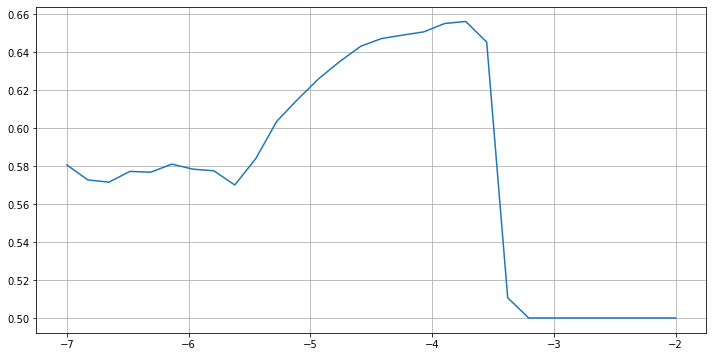

0.02413389654491333 -3.724137931034482


In [11]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -4.0
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_1, y_train_1)

# Store optimal model
optimal_sgl_1 = optimal_sgl

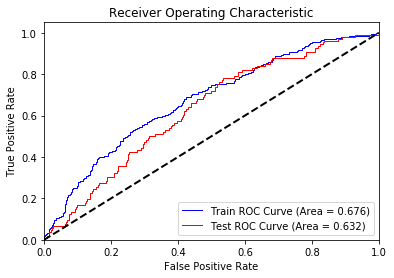

In [10]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_1)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_1)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_1, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[0] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_1, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[0] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

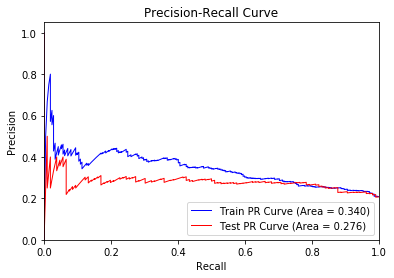

In [11]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_1, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[0] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_1, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[0] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [12]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_1 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_1[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_1, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 17


,HIF,Beta,Cluster
468,REGION PROPERTIES: FRACTAL DIMENSION OF NECROSIS_HE,0.033765,2
347,DENSITY RATIO [FIBROBLAST CELLS] IN [[ESI_0080] OVER [EPITHELIAL]]_HE,0.031183,12
465,REGION PROPERTIES: FRACTAL DIMENSION OF LARGEST REGION OF NECROSIS_HE,0.026499,2
353,DENSITY RATIO [FIBROBLAST CELLS] IN [[TUMOR] OVER [EPITHELIAL]]_HE,0.022693,12
558,REGION PROPERTIES: TOTAL MAJOR AXIS LENGTH (MM) OF NECROSIS_HE,0.022335,2
488,REGION PROPERTIES: MINOR AXIS LENGTH (MM) OF LARGEST REGION OF NECROSIS_HE,0.020145,2
563,REGION PROPERTIES: TOTAL MINOR AXIS LENGTH (MM) OF NECROSIS_HE,0.018785,2
543,REGION PROPERTIES: TOTAL CONVEX AREA (MM2) OF NECROSIS_HE,0.013693,2
438,REGION PROPERTIES: CONVEX AREA (MM2) OF LARGEST REGION OF NECROSIS_HE,0.010597,2
483,REGION PROPERTIES: MAJOR AXIS LENGTH (MM) OF LARGEST REGION OF NECROSIS_HE,0.010582,2


### Outer Loop 2

In [14]:
# Define outer loop train and test
X_train_2 = np.array(X_train_A.append(X_train_C))
y_train_2 = np.array(y_train_A.append(y_train_C))
print(X_train_2.shape, y_train_2.shape)

X_test_2 = np.array(X_train_B)
y_test_2 = np.array(y_train_B)
print(X_test_2.shape, y_test_2.shape)

(1022, 607) (1022,)
(511, 607) (511,)


In [32]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_2, y_train_2)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_2, y_train_2):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_2[train_index], X_train_2[test_index]
        y_train, y_test = y_train_2[train_index], y_train_2[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.5853950480565467, 0.5885395731648962, 0.5886072488139671, 0.5793001380856678, 0.5702063081908043, 0.5926281393981652, 0.6042546791900797, 0.5674692041617105, 0.5844886045144444, 0.5999166017253873, 0.5767646938189573, 0.5712002515620087, 0.5348290335370438, 0.5999234376495358, 0.6076035984304717, 0.6048569241075701, 0.6030071230329629, 0.6071189314083371, 0.6057038951095799, 0.6080479335001299, 0.6072809428106585, 0.6021676715475165, 0.5960406327331392, 0.5585298661526051, 0.5009112286890065, 0.5009994121105232, 0.5, 0.5, 0.5, 0.5]


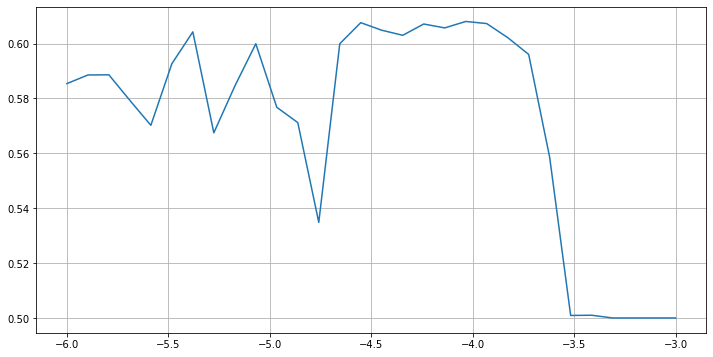

0.01769483024496462 -4.0344827586206895


In [34]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -4.3
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_2, y_train_2)

# Store optimal model
optimal_sgl_2 = optimal_sgl

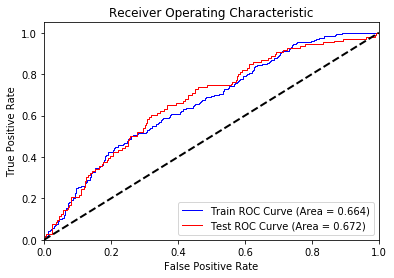

In [15]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_2)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_2)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_2, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[1] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[1] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

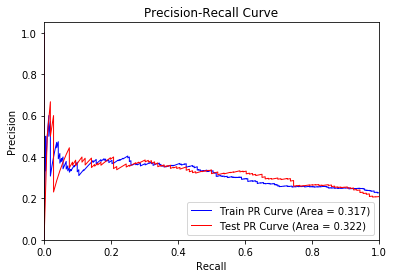

In [16]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_2, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[1] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_2, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[1] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [17]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_2 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_2[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_2, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 38


,HIF,Beta,Cluster
465,REGION PROPERTIES: FRACTAL DIMENSION OF LARGEST REGION OF NECROSIS_HE,0.031314,2
244,COUNT PROP [PLASMA CELLS] IN [[STROMA] OVER [TUMOR]]_HE,0.027906,16
350,DENSITY RATIO [FIBROBLAST CELLS] IN [[STROMA] OVER [EPITHELIAL]]_HE,0.018437,12
288,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [[CANCER CELLS] SELECTED BY...,0.016049,13
125,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF PLASMA IN ESI_0080_HE,0.015950,9
604,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,0.013862,9
2,AREA (MM2) OF [NECROSIS] IN [TISSUE]_HE,0.012021,2
291,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [[CANCER CELLS] SELECTED BY...,0.011243,13
185,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF PLASMA IN ESI_0080_HE,0.010446,9
353,DENSITY RATIO [FIBROBLAST CELLS] IN [[TUMOR] OVER [EPITHELIAL]]_HE,0.010208,12


### Outer Loop 3

In [16]:
# Define outer loop train and test
X_train_3 = np.array(X_train_B.append(X_train_C))
y_train_3 = np.array(y_train_B.append(y_train_C))
print(X_train_3.shape, y_train_3.shape)

X_test_3 = np.array(X_train_A)
y_test_3 = np.array(y_train_A)
print(X_test_3.shape, y_test_3.shape)

(1022, 607) (1022,)
(511, 607) (511,)


In [40]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_3, y_train_3)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_3, y_train_3):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_3[train_index], X_train_3[test_index]
        y_train, y_test = y_train_3[train_index], y_train_3[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.6142029996035163, 0.591126286862721, 0.5628952873138919, 0.5914427901508004, 0.6205761316872428, 0.6491837906566589, 0.5967563539914961, 0.6168341468083071, 0.593209192950795, 0.5945784285577568, 0.6304656631530017, 0.6450275487743189, 0.6453160247733891, 0.6453912199390235, 0.6480893592004703, 0.6482096714654855, 0.6492008804670304, 0.6501633785871512, 0.6497915043134681, 0.6486341823551126, 0.6463188548459866, 0.6412213062083864, 0.6296309968144593, 0.6152817084341632, 0.602614740986834, 0.5351236618678479, 0.5089065255731923, 0.5, 0.5, 0.5]


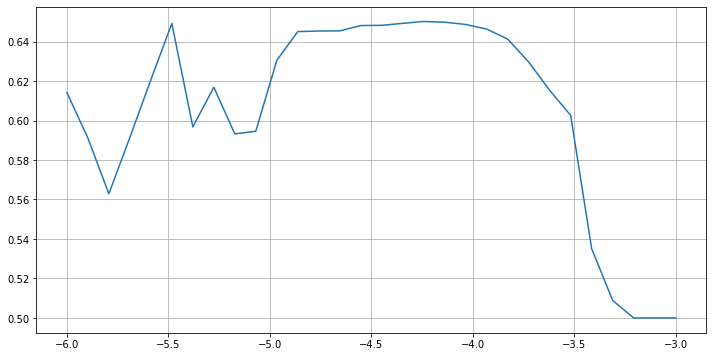

0.014387733001540358 -4.241379310344827


In [42]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -4.0
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_3, y_train_3)

# Store optimal model
optimal_sgl_3 = optimal_sgl

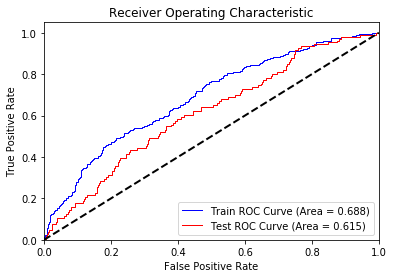

In [20]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_3)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_3)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_3, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[2] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_3, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[2] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

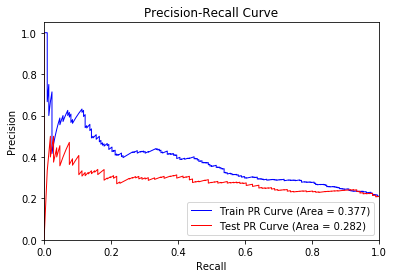

In [21]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_3, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[2] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_3, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[2] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [22]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_3 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_3[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_3, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 26


,HIF,Beta,Cluster
468,REGION PROPERTIES: FRACTAL DIMENSION OF NECROSIS_HE,0.045024,2
388,DENSITY RATIO [PLASMA CELLS] IN [[STROMA] OVER [TUMOR]]_HE,0.027901,4
347,DENSITY RATIO [FIBROBLAST CELLS] IN [[ESI_0080] OVER [EPITHELIAL]]_HE,0.023589,12
376,DENSITY RATIO [MACROPHAGE CELLS] IN [[STROMA] OVER [TUMOR]]_HE,0.020668,4
352,DENSITY RATIO [FIBROBLAST CELLS] IN [[STROMA] OVER [TUMOR]]_HE,0.019427,4
483,REGION PROPERTIES: MAJOR AXIS LENGTH (MM) OF LARGEST REGION OF NECROSIS_HE,0.018900,2
185,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF PLASMA IN ESI_0080_HE,0.015248,9
353,DENSITY RATIO [FIBROBLAST CELLS] IN [[TUMOR] OVER [EPITHELIAL]]_HE,0.010378,12
186,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF PLASMA IN STROMA_HE,0.010375,9
488,REGION PROPERTIES: MINOR AXIS LENGTH (MM) OF LARGEST REGION OF NECROSIS_HE,0.010106,2


## Compute Ensemble Model

In [23]:
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta_1": betas_1, 
    "Beta_2": betas_2,
    "Beta_3": betas_3,
    "Cluster": clusters['x']
    }
)
betas_df['Beta'] = (betas_df['Beta_1'] + betas_df['Beta_2'] + betas_df['Beta_3'])/3.0
betas_df.sort_values(by="Beta", ascending=False)

,HIF,Beta_1,Beta_2,Beta_3,Cluster,Beta
468,REGION PROPERTIES: FRACTAL DIMENSION OF NECROSIS_HE,0.033765,0.000000,0.045024,2,0.026263
465,REGION PROPERTIES: FRACTAL DIMENSION OF LARGEST REGION OF NECROSIS_HE,0.026499,0.031314,0.000000,2,0.019271
347,DENSITY RATIO [FIBROBLAST CELLS] IN [[ESI_0080] OVER [EPITHELIAL]]_HE,0.031183,0.000000,0.023589,12,0.018257
353,DENSITY RATIO [FIBROBLAST CELLS] IN [[TUMOR] OVER [EPITHELIAL]]_HE,0.022693,0.010208,0.010378,12,0.014426
558,REGION PROPERTIES: TOTAL MAJOR AXIS LENGTH (MM) OF NECROSIS_HE,0.022335,0.008646,0.001384,2,0.010788
...,...,...,...,...,...,...
238,COUNT PROP [PLASMA CELLS] IN [[EPITHELIAL] OVER [TUMOR]]_HE,0.000000,-0.027906,0.000000,16,-0.009302
473,REGION PROPERTIES: LACUNARITY OF LARGEST REGION OF EPITHELIAL_HE,0.000000,0.000000,-0.029722,4,-0.009907
380,DENSITY RATIO [PLASMA CELLS] IN [[EPITHELIAL] OVER [ESI_0080]]_HE,0.000000,-0.036073,0.000000,16,-0.012024
346,DENSITY RATIO [FIBROBLAST CELLS] IN [[EPITHELIAL] OVER [TUMOR]]_HE,-0.030996,-0.005442,-0.001781,12,-0.012739


## Compute Final Train / Test Metrics

In [24]:
print(training_aurocs)
print(np.mean(training_aurocs), np.std(training_aurocs))

[0.6757104588865595, 0.6639995341253203, 0.6879221989284883]
0.6758773973134561 0.00976710035953912


In [25]:
print(generalization_aurocs)
print(np.mean(generalization_aurocs), np.std(generalization_aurocs))

[0.631982296762171, 0.6721174004192872, 0.6150710458886559]
0.6397235810233713 0.02392372954227876


In [26]:
print(training_auprcs)
print(np.mean(training_auprcs), np.std(training_auprcs))

[0.3404840724195683, 0.31739987139429576, 0.3765087639243298]
0.3447975692460646 0.024323102669217236


In [27]:
print(generalization_auprcs)
print(np.mean(generalization_auprcs), np.std(generalization_auprcs))

[0.2760687403486386, 0.3218175626151868, 0.2822449551693459]
0.29337708604439044 0.020267904645167343


## Evaluate Hold-Out Set

In [18]:
holdout_df = pd.read_csv("{0}/data/genetic_data/HRD/datasets/pancancer.HRD_Score.joined.HOLDOUT.csv".format(working_dir))
holdout_df = holdout_df.iloc[:,1:]
holdout_df

,bcr_patient_barcode,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,AREA.PROP...EPITHELIAL..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...ESI_0080..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...STROMA..OVER..TUMOR...IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,...,TOTAL..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,TOTAL..MACROPHAGE.CELLS..IN..ESI_0080._HE,TOTAL..MACROPHAGE.CELLS..IN..STROMA._HE,TOTAL..MACROPHAGE.CELLS..IN..TUMOR._HE,TOTAL..PLASMA.CELLS..IN..EPITHELIAL._HE,TOTAL..PLASMA.CELLS..IN..ESI_0080._HE,TOTAL..PLASMA.CELLS..IN..STROMA._HE,TOTAL..PLASMA.CELLS..IN..TUMOR._HE,HRD_Score,HRD_Score_Binarized
0,TCGA-A2-A04N,34.327408,81.342520,0.551184,62.415296,96.742704,0.354832,0.840813,0.645168,6633.257717,...,1813,4109,7559,9372,1564,2336,2231,3795,7,0
1,TCGA-A2-A04P,18.961888,32.686732,6.767424,46.949360,65.911248,0.287688,0.495920,0.712312,5611.085772,...,4956,12171,33449,38405,1385,5787,12023,13408,83,1
2,TCGA-A2-A04Q,2.042160,2.735584,1.230176,7.568592,9.610752,0.212487,0.284638,0.787513,3935.741179,...,413,1643,6123,6536,849,2863,8027,8876,16,0
3,TCGA-A2-A04R,67.331360,79.770572,0.214880,26.367440,93.698800,0.718594,0.851351,0.281406,7514.344122,...,3188,4986,4670,7858,1266,1532,634,1900,36,0
4,TCGA-A2-A04T,24.716784,34.905768,7.369856,42.780144,67.496928,0.366191,0.517146,0.633809,5589.983127,...,3673,12495,38551,42224,2081,8924,20944,23025,77,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,TCGA-85-A510,42.810968,71.876072,71.635612,89.004812,131.815780,0.324779,0.545277,0.675221,5849.430848,...,6581,33044,80904,87485,1912,28761,99357,101269,31,0
484,TCGA-85-A512,47.872360,35.150752,10.031736,22.948752,70.821112,0.675962,0.496332,0.324038,6923.732594,...,6118,10883,11042,17160,902,3880,5740,6642,48,1
485,TCGA-85-A513,20.681632,48.952788,4.349976,58.916880,79.598512,0.259824,0.614996,0.740176,6355.898094,...,10550,41797,96434,106984,3846,52270,78530,82376,24,0
486,TCGA-85-A53L,107.337592,179.691200,79.234320,183.314796,290.652388,0.369299,0.618234,0.630701,6385.322963,...,21633,73755,159376,181009,7270,79853,205016,212286,53,1


In [19]:
# Normalize HIFs and define X, y
X_holdout = holdout_df.iloc[:,1:608]
X_normalized_holdout = (X_holdout-X_holdout.mean())/X_holdout.std()
X_normalized_holdout

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,AREA.PROP...EPITHELIAL..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...ESI_0080..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...STROMA..OVER..TUMOR...IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,...,TOTAL..LYMPHOCYTE.CELLS..IN..STROMA._HE,TOTAL..LYMPHOCYTE.CELLS..IN..TUMOR._HE,TOTAL..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,TOTAL..MACROPHAGE.CELLS..IN..ESI_0080._HE,TOTAL..MACROPHAGE.CELLS..IN..STROMA._HE,TOTAL..MACROPHAGE.CELLS..IN..TUMOR._HE,TOTAL..PLASMA.CELLS..IN..EPITHELIAL._HE,TOTAL..PLASMA.CELLS..IN..ESI_0080._HE,TOTAL..PLASMA.CELLS..IN..STROMA._HE,TOTAL..PLASMA.CELLS..IN..TUMOR._HE
0,-0.270825,0.487318,-0.543623,0.399060,0.080319,-0.763761,1.339522,0.763761,0.451720,1.233762,...,-0.551333,-0.572419,-0.432631,-0.541646,-0.387093,-0.416745,-0.310110,-0.554387,-0.496429,-0.511075
1,-0.707553,-0.605734,-0.102278,-0.023028,-0.405845,-1.187161,-1.017196,1.187161,-1.066522,-0.669973,...,1.053834,0.861652,0.107904,0.041196,0.401534,0.378035,-0.344641,-0.370509,-0.237215,-0.269776
2,-1.188455,-1.278586,-0.495416,-1.097787,-1.293616,-1.661369,-2.460931,1.661369,-3.554927,-1.911318,...,-0.484023,-0.535083,-0.673404,-0.719926,-0.430835,-0.494381,-0.448042,-0.526307,-0.342997,-0.383535
3,0.667233,0.452004,-0.567501,-0.584739,0.032321,1.530069,1.411530,-1.530069,1.760406,1.582733,...,-0.673575,-0.558939,-0.196158,-0.478243,-0.475094,-0.458191,-0.367598,-0.597226,-0.538704,-0.558641
4,-0.543984,-0.555883,-0.059507,-0.136812,-0.380841,-0.692132,-0.872157,0.692132,-1.097866,-0.301302,...,0.622339,0.507164,-0.112747,0.064620,0.556945,0.482580,-0.210374,-0.203362,-0.001059,-0.028378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,-0.029700,0.274654,4.503278,1.124727,0.633366,-0.953273,-0.679935,0.953273,-0.712506,-1.443047,...,0.575308,0.471058,0.387373,1.550210,1.847047,1.721602,-0.242976,0.853603,2.074685,1.935643
484,0.114158,-0.550380,0.129483,-0.678040,-0.328424,1.261238,-1.014387,-1.261238,0.883165,-0.718585,...,-0.631977,-0.615349,0.307745,-0.051920,-0.280999,-0.203548,-0.437818,-0.472119,-0.403539,-0.439611
485,-0.658673,-0.240317,-0.273914,0.303583,-0.190018,-1.362867,-0.203528,1.362867,0.039755,0.092770,...,1.365847,1.235078,1.069963,2.183008,2.320102,2.255388,0.130116,2.106220,1.523354,1.461406
486,1.804313,2.696720,5.042776,3.698585,3.137971,-0.672535,-0.181403,0.672535,0.083460,-0.098648,...,4.811760,4.423551,2.976024,4.493412,4.237360,4.281826,0.790649,3.575911,4.871684,4.722307


In [20]:
y_holdout = holdout_df.iloc[:,609]
print(np.sum(y_holdout))

105


In [ ]:
X_normalized_holdout = np.array(X_normalized_holdout)
y_pred_probs_1 = optimal_sgl_1.predict_proba(X_normalized_holdout)[1] # predicted probability y = 1
y_pred_probs_2 = optimal_sgl_2.predict_proba(X_normalized_holdout)[1]
y_pred_probs_3 = optimal_sgl_3.predict_proba(X_normalized_holdout)[1] 

In [ ]:
# Ensemble (average) predictions
y_pred_probs_ensemble = np.mean(np.array([list(y_pred_probs_1), list(y_pred_probs_2), list(y_pred_probs_3)]), axis=0)
# y_pred_probs_ensemble

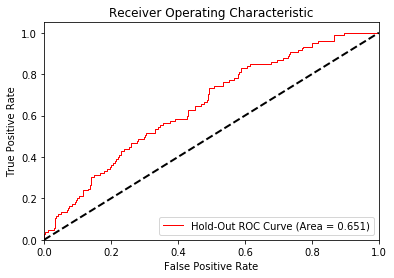

In [33]:
# Hold Out ROC
fpr, tpr, thresholds = roc_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Hold-Out ROC Curve (Area = %0.3f)' % roc_auc)

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Original ROC area: 0.651


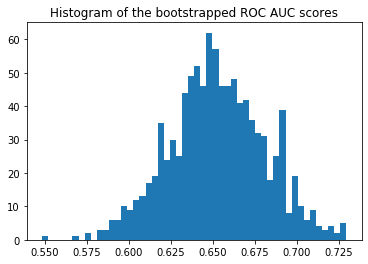

Confidence interval for the score: [0.596 - 0.709]


In [34]:
# Generate ROC 95% CI

print("Original ROC area: {:0.3f}".format(roc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_holdout[indices], y_pred_probs_ensemble[indices])
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

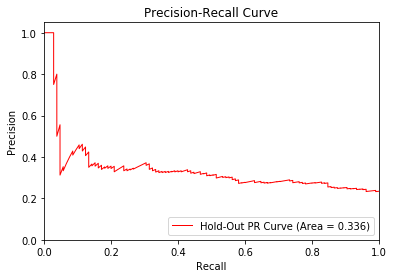

In [35]:
# Hold Out PR Curve
precision, recall, thresholds = precision_recall_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Hold-Out PR Curve (Area = %0.3f)' % prc_auc)

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

Original PRC area: 0.336


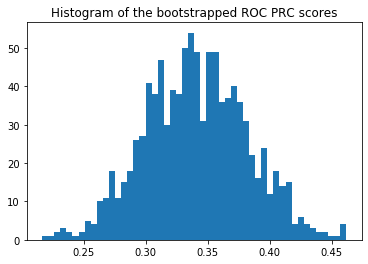

Confidence interval for the score: [0.263 - 0.421]


In [36]:
# Generate PRC 95% CI
print("Original PRC area: {:0.3f}".format(prc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    precision, recall, thresholds = precision_recall_curve(y_holdout[indices], y_pred_probs_ensemble[indices], pos_label=1)
    score = auc(recall, precision)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC PRC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))